In [1]:
# Configuration

# --- Standard Libraries ---
import sys
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
import os
import json
import time
import copy
import cmath
import pickle
import logging
import argparse

# Path configuration (only run once)
sys.path.append(gems_tco_path)

# --- Third-Party Libraries ---
from pathlib import Path
from typing import Optional, List, Tuple, Dict, Any, Callable
from json import JSONEncoder

# Data manipulation and analysis
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import typer

# Torch and Numerical Libraries
import torch
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
from torch.nn import Parameter
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import matplotlib.pyplot as plt 

# --- Custom (GEMS_TCO) Imports ---
import GEMS_TCO
from GEMS_TCO import kernels_reparam_space_time_gpu
from GEMS_TCO import data_preprocess, data_preprocess as dmbh
from GEMS_TCO import orderings as _orderings 

from GEMS_TCO import alg_optimization
from GEMS_TCO import configuration as config
from GEMS_TCO.data_loader import load_data2
from GEMS_TCO import debiased_whittle


load monthly data

In [19]:
	
# reflected location error in ozone data simulation

import torch
import torch.fft
import numpy as np
import sys
# Add your custom path
gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)
import os
import logging
import argparse # Argument parsing

# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import torch
import torch.optim as optim
import copy                    # clone tensor
import time
from sklearn.neighbors import BallTree
# Custom imports


from GEMS_TCO import kernels_reparam_space_time_gpu as kernels_reparam_space_time_gpu


# from GEMS_TCO import kernels_gpu_past1  as kernels_gpu_past1


from GEMS_TCO import alg_optimization, BaseLogger

from typing import Optional, List, Tuple
from pathlib import Path
import typer
import json
from json import JSONEncoder
from GEMS_TCO import configuration as config
from GEMS_TCO.data_loader import load_data2, exact_location_filter
from GEMS_TCO import debiased_whittle
from torch.nn import Parameter

# --- 1. CONFIGURATION ---
# Check for Mac GPU (MPS) first, then CUDA, then CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Optional: Force CPU if you encounter Cholesky errors later
# DEVICE = torch.device("cpu") 
DTYPE = torch.float32 if DEVICE.type == 'mps' else torch.float64

print(f"Simulating on: {DEVICE}")

# TRUE PARAMETERS
init_sigmasq   = 13.059
init_range_lon = 0.195 
init_range_lat = 0.154 
init_advec_lat = 0.0418
init_range_time = 1.0
init_advec_lon = -0.1689
init_nugget    = 0.247

# Map parameters
init_phi2 = 1.0 / init_range_lon
init_phi1 = init_sigmasq * init_phi2
init_phi3 = (init_range_lon / init_range_lat)**2
init_phi4 = (init_range_lon / init_range_time)**2

# Create Initial Parameters
initial_vals = [np.log(init_phi1), np.log(init_phi2), np.log(init_phi3), 
                np.log(init_phi4), init_advec_lat, init_advec_lon, np.log(init_nugget)]

params_list = [
    torch.tensor([val], requires_grad=True, dtype=DTYPE, device=DEVICE)
    for val in initial_vals
]

# Mean Ozone
OZONE_MEAN = 260.0

# --- 2. EXACT COVARIANCE ---
def get_model_covariance_on_grid(lags_x, lags_y, lags_t, params):
    phi1, phi2, phi3, phi4 = torch.exp(params[0]), torch.exp(params[1]), torch.exp(params[2]), torch.exp(params[3])
    advec_lat, advec_lon = params[4], params[5]
    sigmasq = phi1 / phi2

    u_lat_eff = lags_x - advec_lat * lags_t
    u_lon_eff = lags_y - advec_lon * lags_t
    
    dist_sq = (u_lat_eff.pow(2) * phi3) + (u_lon_eff.pow(2)) + (lags_t.pow(2) * phi4)
    distance = torch.sqrt(dist_sq + 1e-8)
    
    return sigmasq * torch.exp(-distance * phi2)

# --- 3. FFT SIMULATION ---
def generate_exact_gems_field(lat_coords, lon_coords, t_steps, params):
    Nx = len(lat_coords)
    Ny = len(lon_coords)
    Nt = t_steps
    
    print(f"Exact Grid Size: {Nx} (Lat) x {Ny} (Lon) x {Nt} (Time) = {Nx*Ny*Nt} points")
    
    dlat = float(lat_coords[1] - lat_coords[0])
    dlon = float(lon_coords[1] - lon_coords[0])
    dt = 1.0 
    
    Px, Py, Pt = 2*Nx, 2*Ny, 2*Nt
    
    Lx_len = Px * dlat   
    lags_x = torch.arange(Px, device=DEVICE, dtype=DTYPE) * dlat
    lags_x[Px//2:] -= Lx_len 
    
    Ly_len = Py * dlon   
    lags_y = torch.arange(Py, device=DEVICE, dtype=DTYPE) * dlon
    lags_y[Py//2:] -= Ly_len

    Lt_len = Pt * dt     
    lags_t = torch.arange(Pt, device=DEVICE, dtype=DTYPE) * dt
    lags_t[Pt//2:] -= Lt_len

    L_x, L_y, L_t = torch.meshgrid(lags_x, lags_y, lags_t, indexing='ij')
    C_vals = get_model_covariance_on_grid(L_x, L_y, L_t, params)

    S = torch.fft.fftn(C_vals)
    S.real = torch.clamp(S.real, min=0)

    random_phase = torch.fft.fftn(torch.randn(Px, Py, Pt, device=DEVICE, dtype=DTYPE))
    weighted_freq = torch.sqrt(S.real) * random_phase
    field_sim = torch.fft.ifftn(weighted_freq).real
    
    return field_sim[:Nx, :Ny, :Nt]

# --- 4. REGULAR GRID FUNCTIONS (FIXED WITH ROUNDING) ---

def make_target_grid(lat_start, lat_end, lat_step, lon_start, lon_end, lon_step, device, dtype):
    """
    Constructs a grid explicitly from start to end.
    CRITICAL: Includes rounding to 4 decimal places to prevent "Tensor size does not match" errors.
    """
    # 1. Generate Latitudes (Descending from 5.0)
    # We use a small epsilon to ensure the 'end' is included if it's a multiple
    lats = torch.arange(lat_start, lat_end - 0.0001, lat_step, device=device, dtype=dtype)
    lats = torch.round(lats * 10000) / 10000  # <--- FIX: Round to 4 decimals
    
    # 2. Generate Longitudes (Descending from 133.0)
    lons = torch.arange(lon_start, lon_end - 0.0001, lon_step, device=device, dtype=dtype)
    lons = torch.round(lons * 10000) / 10000  # <--- FIX: Round to 4 decimals

    print(f"Grid Generation debug: Lat Range {lats[0]:.4f}-{lats[-1]:.4f}, Lon Range {lons[0]:.4f}-{lons[-1]:.4f}")
    print(f"Unique Lats: {len(lats)}, Unique Lons: {len(lons)}")

    # 3. Meshgrid (indexing='ij' -> Lat is rows, Lon is cols)
    grid_lat, grid_lon = torch.meshgrid(lats, lons, indexing='ij')

    # 4. Flatten
    flat_lats = grid_lat.flatten()
    flat_lons = grid_lon.flatten()

    # 5. Stack
    center_points = torch.stack([flat_lats, flat_lons], dim=1)
    
    # Return grid AND dimensions (Nx, Ny) for verification
    return center_points, len(lats), len(lons)

def coarse_by_center_tensor(input_map_tensors: dict, target_grid_tensor: torch.Tensor):
    coarse_map = {}
    
    # BallTree requires CPU Numpy
    query_points_np = target_grid_tensor.cpu().numpy()
    query_points_rad = np.radians(query_points_np)
    
    for key, val_tensor in input_map_tensors.items():
        # Source locations (Perturbed)
        source_locs_np = val_tensor[:, :2].cpu().numpy()
        source_locs_rad = np.radians(source_locs_np)
        
        # NN Search
        tree = BallTree(source_locs_rad, metric='haversine')
        dist, ind = tree.query(query_points_rad, k=1)
        nearest_indices = ind.flatten()
        
        # Map values back to tensor
        indices_tensor = torch.tensor(nearest_indices, device=val_tensor.device, dtype=torch.long)
        gathered_vals = val_tensor[indices_tensor, 2]
        gathered_times = val_tensor[indices_tensor, 3]
        
        # Construct Regular Tensor
        new_tensor = torch.stack([
            target_grid_tensor[:, 0], # Regular Lat
            target_grid_tensor[:, 1], # Regular Lon
            gathered_vals,            # Mapped Value
            gathered_times            # Mapped Time
        ], dim=1)
        
        coarse_map[key] = new_tensor

    return coarse_map

# --- 5. EXECUTION ---

# Simulation Grid (Base)
lats_sim = torch.arange(0, 5.0 + 0.001, 0.044, device=DEVICE, dtype=DTYPE)
lons_sim = torch.arange(123.0, 133.0 + 0.001, 0.063, device=DEVICE, dtype=DTYPE)
t_def = 8
LOC_ERR_STD = 0.01 

print("1. Generating True Field...")
sim_field = generate_exact_gems_field(lats_sim, lons_sim, t_def, params_list)

print("2. Formatting Output...")
input_map = {}
aggregated_list = [] 
nugget_std = torch.sqrt(torch.exp(params_list[6]))

# Create Base Grid for Perturbation (Lat/Lon Descending)
lats_flip = torch.flip(lats_sim, dims=[0])
lons_flip = torch.flip(lons_sim, dims=[0])
grid_lat, grid_lon = torch.meshgrid(lats_flip, lons_flip, indexing='ij')
flat_lats = grid_lat.flatten()
flat_lons = grid_lon.flatten()

for t in range(t_def):
    field_t = sim_field[:, :, t] 
    field_t_flipped = torch.flip(field_t, dims=[0, 1]) 
    flat_vals = field_t_flipped.flatten()
    
    # Add Nugget Noise
    obs_vals = flat_vals + (torch.randn_like(flat_vals) * nugget_std) + OZONE_MEAN
    
    # Add Location Perturbation
    lat_noise = torch.randn_like(flat_lats) * LOC_ERR_STD
    lon_noise = torch.randn_like(flat_lons) * LOC_ERR_STD
    perturbed_lats = flat_lats + lat_noise
    perturbed_lons = flat_lons + lon_noise

    time_val = 21.0 + t
    flat_times = torch.full_like(flat_lats, time_val)
    
    # Create the Irregular Data Tensor
    row_tensor = torch.stack([perturbed_lats, perturbed_lons, obs_vals, flat_times], dim=1)
    
    key_str = f'2024_07_y24m07day01_hm{t:02d}:53'
    input_map[key_str] = row_tensor.detach()
    aggregated_list.append(input_map[key_str])

aggregated_data = torch.cat(aggregated_list, dim=0)
print(f"Aggregated Tensor Shape (Perturbed): {aggregated_data.shape}")

# --- 6. ENFORCE REGULAR GRID ---
print("\n--- Enforcing Regular Grid ---")

# Step sizes
step_lat = 0.044
step_lon = 0.063

# Generate Target Grid: TOP-DOWN to ensure 5.0 and 133.0 are included
# 5.0 -> 0.0 (Descending) | 133.0 -> 123.0 (Descending)
target_grid, Nx_reg, Ny_reg = make_target_grid(
    lat_start=5.0, lat_end=0.0, lat_step=-step_lat,
    lon_start=133.0, lon_end=123.0, lon_step=-step_lon,
    device=DEVICE, dtype=DTYPE
)

print(f"Target Regular Grid Shape: {target_grid.shape}")

# Map Perturbed Data to Regular Grid
coarse_map = coarse_by_center_tensor(input_map, target_grid)

# Aggregate Clean Data
coarse_aggregated_list = list(coarse_map.values())
coarse_aggregated_data = torch.cat(coarse_aggregated_list, dim=0)

# --- CRITICAL: OVERWRITE VARIABLES FOR DOWNSTREAM TASKS ---
input_map = coarse_map
aggregated_data = coarse_aggregated_data

print("\n--- Regularization Complete ---")
print(f"Final Data Shape: {aggregated_data.shape}")

# --- 7. VERIFICATION ---
# Verify integrity for Whittle (Must be perfect rect)
u_lat = torch.unique(aggregated_data[:, 0])
u_lon = torch.unique(aggregated_data[:, 1])

print(f"\nGrid Integrity Check:")
print(f"Unique Latitudes: {len(u_lat)}")
print(f"Unique Longitudes: {len(u_lon)}")
print(f"Expected Total Points per Day: {len(u_lat) * len(u_lon)}")
print(f"Actual Points per Day: {aggregated_data.shape[0] // t_def}")

if (len(u_lat) * len(u_lon)) == (aggregated_data.shape[0] // t_def):
    print("SUCCESS: Grid is perfect and ready for Whittle.")
else:
    print("WARNING: Grid mismatch detected! Whittle will fail.")


inputmap = coarse_map
aggregated_data = coarse_aggregated_data

Simulating on: cpu
1. Generating True Field...
Exact Grid Size: 114 (Lat) x 159 (Lon) x 8 (Time) = 145008 points
2. Formatting Output...
Aggregated Tensor Shape (Perturbed): torch.Size([145008, 4])

--- Enforcing Regular Grid ---
Grid Generation debug: Lat Range 5.0000-0.0280, Lon Range 133.0000-123.0460
Unique Lats: 114, Unique Lons: 159
Target Regular Grid Shape: torch.Size([18126, 2])

--- Regularization Complete ---
Final Data Shape: torch.Size([145008, 4])

Grid Integrity Check:
Unique Latitudes: 114
Unique Longitudes: 159
Expected Total Points per Day: 18126
Actual Points per Day: 18126
SUCCESS: Grid is perfect and ready for Whittle.


In [20]:
from GEMS_TCO import orderings as _orderings
import torch
import numpy as np
from typing import Tuple

# inputmap, aggregated_data 변수는 외부에 있다고 가정

def get_spatial_ordering(
        input_maps: dict,
        mm_cond_number: int = 10
    ) -> Tuple[np.ndarray, list]: # 반환 타입힌트 변경 (list)
        
        key_list = list(input_maps.keys())
        data_for_coord = input_maps[key_list[0]]
        
        # Tensor -> Numpy 변환
        if isinstance(data_for_coord, torch.Tensor):
            data_for_coord = data_for_coord.cpu().numpy()

        x1 = data_for_coord[:, 0]
        y1 = data_for_coord[:, 1]
        
        coords1 = np.stack((x1, y1), axis=-1)

        # 1. MaxMin Ordering
        ord_mm = _orderings.maxmin_cpp(coords1)
        
        # 2. Reorder coordinates
        data_for_coord_reordered = data_for_coord[ord_mm]
        coords1_reordered = np.stack(
            (data_for_coord_reordered[:, 0], data_for_coord_reordered[:, 1]), 
            axis=-1
        )
        
        # 3. Calculate nearest neighbors map (Dictionary 반환됨)
        nns_map_dict = _orderings.find_nns_l2(locs=coords1_reordered, max_nn=mm_cond_number)
        
        # --- 🔴 [FIX 1] Dictionary -> List 변환 (TypeError 방지) ---
        # 키(Key) 순서대로 값(Value)만 뽑아서 리스트로 만듭니다.
        nns_map_list = [nns_map_dict[i] for i in range(len(nns_map_dict))]
        # -----------------------------------------------------
        
        return ord_mm, nns_map_list

# --- 🔴 [FIX 2] mm_cond_number 변경 (16 -> 10) ---
# 16개로 하면 메모리(35)가 터집니다. 3*10 + 5 = 35 이므로 10이 한계입니다.
ord_mm, nns_map = get_spatial_ordering(inputmap, mm_cond_number=15)

# 데이터 재정렬 (이건 그대로 사용)
mm_input_map = {}
for key in inputmap:
    mm_input_map[key] = inputmap[key][ord_mm]




functions setup

--- Simulating on cpu ---
Calculating True Model Diagnostics...
Calculating Wrong Model Diagnostics...


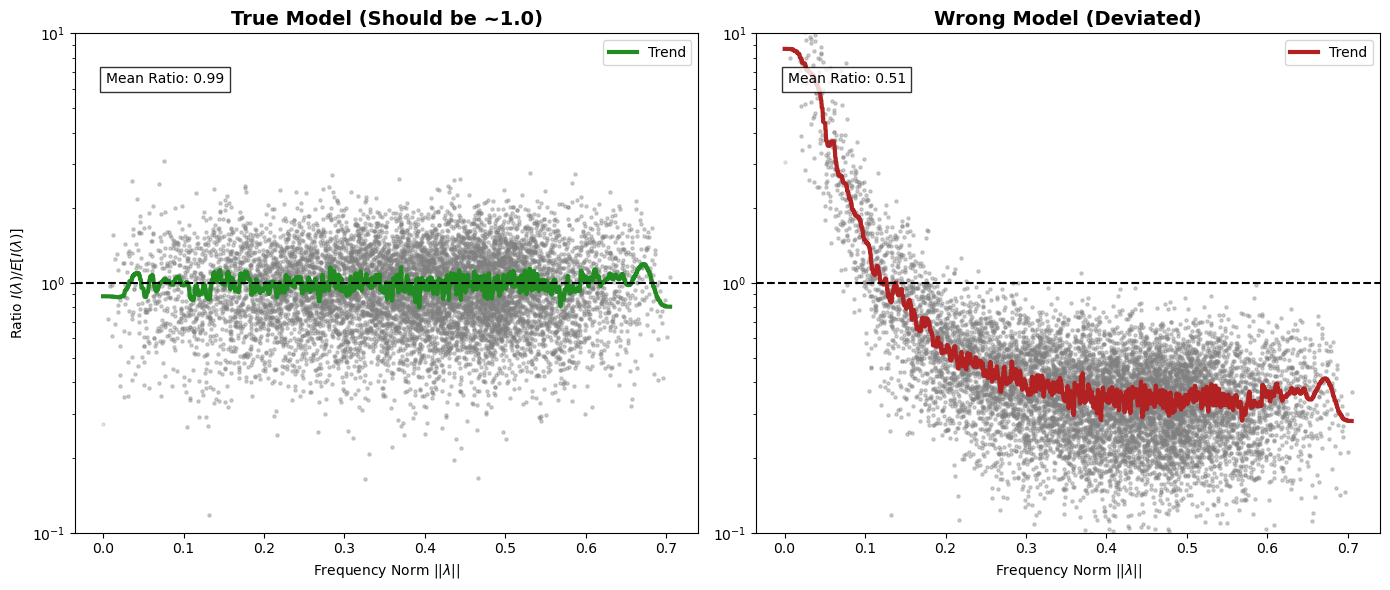

In [35]:
import torch
import torch.fft
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift
from scipy.ndimage import gaussian_filter1d
import cmath

# =========================================================================
# 1. Debiased Whittle Logic (Modified for Simulation)
# =========================================================================
class debiased_whittle_likelihood:
    
    @staticmethod
    def cgn_hamming(u, n1, n2):
        """
        [수정 1] 표준 Hamming Window (Bell Shape)
        부호를 '-'로 변경하여 중앙을 1.0, 가장자리를 0.08로 만듭니다.
        """
        u1, u2 = u
        device = u1.device if isinstance(u1, torch.Tensor) else (u2.device if isinstance(u2, torch.Tensor) else torch.device('cpu'))
        u1_tensor = u1.to(device) if isinstance(u1, torch.Tensor) else torch.tensor(u1, device=device, dtype=torch.float64)
        u2_tensor = u2.to(device) if isinstance(u2, torch.Tensor) else torch.tensor(u2, device=device, dtype=torch.float64)
        n1_eff = float(n1) if n1 > 0 else 1.0
        n2_eff = float(n2) if n2 > 0 else 1.0
        
        # Changed + to -
        hamming1 = 0.54 - 0.46 * torch.cos(2.0 * torch.pi * u1_tensor / n1_eff)
        hamming2 = 0.54 - 0.46 * torch.cos(2.0 * torch.pi * u2_tensor / n2_eff)
        return hamming1 * hamming2

    @staticmethod
    def calculate_taper_autocorrelation_fft(taper_grid, n1, n2, device):
        taper_grid = taper_grid.to(device) 
        H = torch.sum(taper_grid**2)
        if H < 1e-12:
            return torch.zeros((2*n1-1, 2*n2-1), device=device, dtype=taper_grid.dtype)
        N1, N2 = 2 * n1 - 1, 2 * n2 - 1
        taper_fft = torch.fft.fft2(taper_grid, s=(N1, N2))
        power_spectrum = torch.abs(taper_fft)**2
        autocorr_unnormalized = torch.fft.ifft2(power_spectrum).real
        autocorr_shifted = torch.fft.fftshift(autocorr_unnormalized)
        return autocorr_shifted / (H + 1e-12)

    @staticmethod
    def generate_Jvector_tapered(tensor_list, tapering_func, lat_col, lon_col, val_col, device):
        if not tensor_list: return None
        
        # Grid Info (Assuming Regular Grid for Simulation)
        sample = tensor_list[0]
        unique_lats = torch.unique(sample[:, lat_col])
        unique_lons = torch.unique(sample[:, lon_col])
        n1, n2 = len(unique_lats), len(unique_lons)
        
        # Generate Taper
        u1_mesh, u2_mesh = torch.meshgrid(
            torch.arange(n1, device=device, dtype=torch.float64),
            torch.arange(n2, device=device, dtype=torch.float64),
            indexing='ij'
        )
        taper_grid = tapering_func((u1_mesh, u2_mesh), n1, n2)

        fft_results = []
        for tensor in tensor_list:
            grid_val = tensor[:, val_col].reshape(n1, n2)
            # Center data (Zero mean)
            grid_val = grid_val - torch.mean(grid_val)
            
            data_tapered = grid_val * taper_grid
            fft_results.append(torch.fft.fft2(data_tapered))

        J_vector_tensor = torch.stack(fft_results, dim=2)
        H = torch.sum(taper_grid**2)
        norm_factor = (torch.sqrt(1.0 / H) / (2.0 * cmath.pi)).to(device)
        return J_vector_tensor * norm_factor, n1, n2, len(tensor_list), taper_grid

    @staticmethod
    def calculate_sample_periodogram_vectorized(J_vector_tensor):
        J_col = J_vector_tensor.unsqueeze(-1)
        J_row_conj = J_vector_tensor.unsqueeze(-2).conj()
        return J_col @ J_row_conj

    @staticmethod
    def cov_x_spatiotemporal_model_kernel(u1, u2, t, params):
        device = params.device
        phi1, phi2, phi3, phi4 = torch.exp(params[0]), torch.exp(params[1]), torch.exp(params[2]), torch.exp(params[3])
        advec_lat, advec_lon = params[4], params[5]
        nugget = torch.exp(params[6])

        sigmasq = phi1 / (phi2 + 1e-12)
        range_lon_inv = phi2
        range_lat_inv = torch.sqrt(phi3 + 1e-12) * phi2
        beta_scaled_inv = torch.sqrt(phi4 + 1e-12) * phi2 

        u1_adv = u1 - advec_lat * t
        u2_adv = u2 - advec_lon * t
        dist_sq = (u1_adv * range_lat_inv).pow(2) + (u2_adv * range_lon_inv).pow(2) + (t * beta_scaled_inv).pow(2)
        distance = torch.sqrt(dist_sq + 1e-12)
        
        cov_smooth = sigmasq * torch.exp(-distance)
        is_zero_lag = (torch.abs(u1) < 1e-9) & (torch.abs(u2) < 1e-9) & (torch.abs(t) < 1e-9)
        return torch.where(is_zero_lag, cov_smooth + nugget, cov_smooth)

    @staticmethod
    def cn_bar_tapered(u1, u2, t, params, n1, n2, taper_autocorr_grid, delta1, delta2):
        """
        [수정 2] 시뮬레이션용 Direct Kernel Call
        'cov_spatial_difference' (Laplacian Filter)를 거치지 않고 바로 커널을 호출합니다.
        이유: 시뮬레이션 데이터가 필터링되지 않은 Raw Data이기 때문입니다.
        """
        # 물리적 거리로 변환
        phys_u1 = u1 * delta1
        phys_u2 = u2 * delta2
        
        # 필터 없이 바로 커널 호출
        cov_val = debiased_whittle_likelihood.cov_x_spatiotemporal_model_kernel(phys_u1, phys_u2, t, params)
        
        idx1 = torch.clamp((n1 - 1 + u1).long(), 0, 2 * n1 - 2)
        idx2 = torch.clamp((n2 - 1 + u2).long(), 0, 2 * n2 - 2)
        taper_val = taper_autocorr_grid[idx1, idx2]
        
        return cov_val * taper_val

    @staticmethod
    def expected_periodogram_fft_tapered(params, n1, n2, p_time, taper_autocorr_grid, delta1, delta2):
        device = params.device
        u1_mesh, u2_mesh = torch.meshgrid(torch.arange(n1, device=device), torch.arange(n2, device=device), indexing='ij')
        t_lags = torch.arange(p_time, device=device)
        tilde_cn_tensor = torch.zeros((n1, n2, p_time, p_time), dtype=torch.complex128, device=device)

        for q in range(p_time):
            for r in range(p_time):
                t_diff = t_lags[q] - t_lags[r]
                # Aliasing Summation Terms (Approx)
                # 시뮬레이션은 Grid가 조밀하므로 메인 텀(t1)만 계산해도 충분하지만, 안전을 위해 다 더함
                t1 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t2 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t3 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t4 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                tilde_cn_tensor[:, :, q, r] = (t1 + t2 + t3 + t4).to(torch.complex128)

        fft_result = torch.fft.fft2(tilde_cn_tensor, dim=(0, 1)).real
        # Scaling factor: 1 / (4 * pi^2) matches standard DFT definition in some Whittle papers
        return fft_result * (1.0 / (4.0 * cmath.pi**2))

def calculate_periodogram_ratio(data_tensor, params_dict, device):
    # Parameter Unpacking
    sigma_sq = params_dict['sigma_sq']
    range_lat = params_dict['range_lat']
    range_lon = params_dict['range_lon']
    range_time = params_dict['range_time']
    advec_lat = params_dict['advec_lat']
    advec_lon = params_dict['advec_lon']
    nugget = params_dict['nugget']

    phi2 = 1.0 / range_lon
    phi1 = sigma_sq * phi2
    phi3 = (range_lon / range_lat)**2
    phi4 = (range_lon / range_time)**2
    
    params_tensor = torch.tensor([
        np.log(phi1), np.log(phi2), np.log(phi3), np.log(phi4), 
        advec_lat, advec_lon, np.log(nugget)
    ], device=device, dtype=torch.float64)

    # Data Split
    unique_times = torch.unique(data_tensor[:, 3])
    tensor_list = [data_tensor[data_tensor[:, 3] == t] for t in unique_times]
    
    # Calculate Vectors
    J_vec, n1, n2, p_time, taper_grid = debiased_whittle_likelihood.generate_Jvector_tapered(
        tensor_list, debiased_whittle_likelihood.cgn_hamming, 0, 1, 2, device
    )
    
    I_sample = debiased_whittle_likelihood.calculate_sample_periodogram_vectorized(J_vec)
    taper_autocorr = debiased_whittle_likelihood.calculate_taper_autocorrelation_fft(taper_grid, n1, n2, device)
    
    # Simulation Hardcoded Deltas
    DELTA_LAT, DELTA_LON = 0.044, 0.063
    
    I_expected = debiased_whittle_likelihood.expected_periodogram_fft_tapered(
        params_tensor, n1, n2, p_time, taper_autocorr, DELTA_LAT, DELTA_LON
    )

    # Ratio
    diag_sample = torch.diagonal(torch.fft.fftshift(I_sample, dim=(0,1)), dim1=-2, dim2=-1).real
    diag_expected = torch.diagonal(torch.fft.fftshift(I_expected, dim=(0,1)), dim1=-2, dim2=-1)
    
    # Epsilon for stability
    ratio = diag_sample / (diag_expected + 1e-15)
    ratio_avg = torch.mean(ratio, dim=-1).cpu().numpy().flatten()
    
    # Frequency Axis
    freq_lat = fftshift(np.fft.fftfreq(n1))
    freq_lon = fftshift(np.fft.fftfreq(n2))
    g_lon, g_lat = np.meshgrid(freq_lon, freq_lat)
    freq_norm = np.sqrt(g_lat**2 + g_lon**2).flatten()
    
    return freq_norm, ratio_avg

# =========================================================================
# 2. Simulation Logic (Generates Raw Data)
# =========================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float64

def get_model_covariance_on_grid(lags_x, lags_y, lags_t, params):
    phi1, phi2, phi3, phi4 = torch.exp(params[0]), torch.exp(params[1]), torch.exp(params[2]), torch.exp(params[3])
    u_lat, u_lon = lags_x - params[4]*lags_t, lags_y - params[5]*lags_t
    dist = torch.sqrt(u_lat.pow(2)*phi3 + u_lon.pow(2) + lags_t.pow(2)*phi4 + 1e-12)
    return (phi1/phi2) * torch.exp(-dist * phi2)

def generate_simulation():
    print(f"--- Simulating on {DEVICE} ---")
    # Simulation Params (TRUE)
    params = [np.log(13.059/0.195), np.log(1.0/0.195), np.log((0.195/0.154)**2), 
              np.log((0.195/1.0)**2), 0.0418, -0.1689, np.log(0.247)]
    params_t = [torch.tensor(p, device=DEVICE, dtype=DTYPE) for p in params]
    
    lats = torch.arange(0, 5.001, 0.044, device=DEVICE, dtype=DTYPE)
    lons = torch.arange(123.0, 133.001, 0.063, device=DEVICE, dtype=DTYPE)
    t_steps = 8
    Nx, Ny = len(lats), len(lons)
    
    # FFT Based Generation (Circulant Embedding approximation)
    l_x = (torch.arange(2*Nx, device=DEVICE, dtype=DTYPE)*0.044); l_x[Nx:] -= l_x[-1] + 0.044
    l_y = (torch.arange(2*Ny, device=DEVICE, dtype=DTYPE)*0.063); l_y[Ny:] -= l_y[-1] + 0.063
    l_t = (torch.arange(2*t_steps, device=DEVICE, dtype=DTYPE)); l_t[t_steps:] -= l_t[-1] + 1.0
    
    L_x, L_y, L_t = torch.meshgrid(l_x, l_y, l_t, indexing='ij')
    C = get_model_covariance_on_grid(L_x, L_y, L_t, params_t)
    S = torch.fft.fftn(C).real.clamp(min=0)
    noise = torch.fft.fftn(torch.randn_like(S, dtype=DTYPE))
    sim_field = torch.fft.ifftn(torch.sqrt(S) * noise).real[:Nx, :Ny, :t_steps]
    
    aggregated_list = []
    lat_grid, lon_grid = torch.meshgrid(lats, lons, indexing='ij')
    for t in range(t_steps):
        # Adding Nugget Effect + Mean
        val = sim_field[:, :, t] + torch.randn_like(sim_field[:, :, t]) * np.sqrt(0.247) + 260.0
        row = torch.stack([lat_grid.flatten(), lon_grid.flatten(), val.flatten(), torch.full_like(lat_grid.flatten(), t)], dim=1)
        aggregated_list.append(row)
        
    return torch.cat(aggregated_list, dim=0)

# =========================================================================
# 3. Execution & Plotting
# =========================================================================
if __name__ == "__main__":
    # 1. Generate Data (Raw, No Filtering)
    data = generate_simulation()
    
    # 2. Define Parameter Sets
    # Case A: TRUE Parameters
    params_true = {
        'sigma_sq': 13.059, 'range_lon': 0.195, 'range_lat': 0.154, 'range_time': 1.0,
        'advec_lat': 0.0418, 'advec_lon': -0.1689, 'nugget': 0.247
    }
    
    # Case B: WRONG Parameters (Bias & Tilt)
    params_wrong = {
        'sigma_sq': 13.059,    # True: 13.0
        'range_lon': 0.05,   # True: 0.195
        'range_lat': 0.05,
        'range_time': 1.0,
        'advec_lat': 0.0,
        'advec_lon': 0.0,
        'nugget': 0.247
    }
    
    # 3. Calculate Diagnostics
    print("Calculating True Model Diagnostics...")
    x_true, y_true = calculate_periodogram_ratio(data, params_true, DEVICE)
    
    print("Calculating Wrong Model Diagnostics...")
    x_wrong, y_wrong = calculate_periodogram_ratio(data, params_wrong, DEVICE)
    
    # 4. Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    def plot_ax(ax, x, y, title, color):
        ax.scatter(x, y, alpha=0.2, c='gray', s=5)
        # Smooth trend for visibility
        idx = np.argsort(x)
        ax.plot(x[idx], gaussian_filter1d(y[idx], sigma=20), color=color, linewidth=3, label='Trend')
        
        ax.axhline(1.0, linestyle='--', color='black', linewidth=1.5)
        ax.set_yscale('log')
        ax.set_ylim(0.1, 10.0)
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_xlabel(r'Frequency Norm $||\lambda||$')
        ax.legend()
        
        # Mean Text
        ax.text(0.05, 0.9, f'Mean Ratio: {np.mean(y):.2f}', transform=ax.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

    plot_ax(axes[0], x_true, y_true, "True Model (Should be ~1.0)", "forestgreen")
    plot_ax(axes[1], x_wrong, y_wrong, "Wrong Model (Deviated)", "firebrick")
    
    axes[0].set_ylabel(r'Ratio $I(\lambda) / E[I(\lambda)]$')
    plt.tight_layout()
    plt.show()

variance added/ over code average 8 hours below is not

--- Simulating on cpu ---
Grid Size: 114 x 159 x 8 = 145008 Total Points
Calculating True Model Diagnostics (Whitening)...
Calculating Wrong Model Diagnostics (Whitening)...


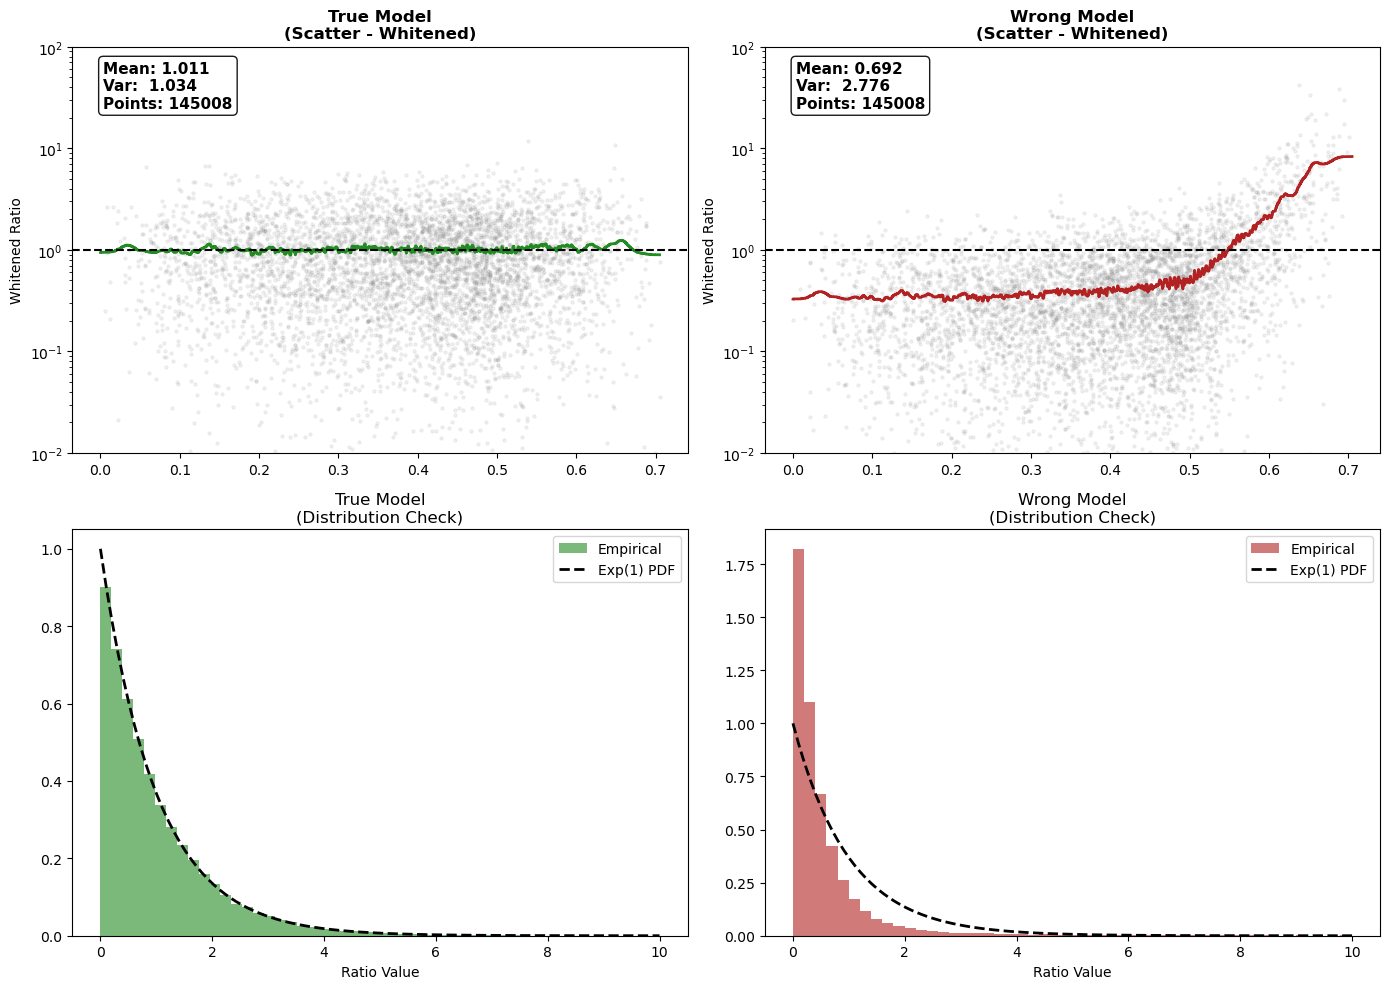

In [71]:
import torch
import torch.fft
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fftshift
from scipy.ndimage import gaussian_filter1d
import cmath

# =========================================================================
# 1. Debiased Whittle Logic (Whitening Supported)
# =========================================================================
class debiased_whittle_likelihood:
    
    @staticmethod
    def cgn_hamming(u, n1, n2):
        u1, u2 = u
        device = u1.device if isinstance(u1, torch.Tensor) else (u2.device if isinstance(u2, torch.Tensor) else torch.device('cpu'))
        u1_tensor = u1.to(device) if isinstance(u1, torch.Tensor) else torch.tensor(u1, device=device, dtype=torch.float64)
        u2_tensor = u2.to(device) if isinstance(u2, torch.Tensor) else torch.tensor(u2, device=device, dtype=torch.float64)
        n1_eff = float(n1) if n1 > 0 else 1.0
        n2_eff = float(n2) if n2 > 0 else 1.0
        
        # Correct Hamming Window (Minus sign)
        hamming1 = 0.54 - 0.46 * torch.cos(2.0 * torch.pi * u1_tensor / n1_eff)
        hamming2 = 0.54 - 0.46 * torch.cos(2.0 * torch.pi * u2_tensor / n2_eff)
        return hamming1 * hamming2

    @staticmethod
    def calculate_taper_autocorrelation_fft(taper_grid, n1, n2, device):
        taper_grid = taper_grid.to(device) 
        H = torch.sum(taper_grid**2)
        if H < 1e-12:
            return torch.zeros((2*n1-1, 2*n2-1), device=device, dtype=taper_grid.dtype)
        N1, N2 = 2 * n1 - 1, 2 * n2 - 1
        taper_fft = torch.fft.fft2(taper_grid, s=(N1, N2))
        power_spectrum = torch.abs(taper_fft)**2
        autocorr_unnormalized = torch.fft.ifft2(power_spectrum).real
        autocorr_shifted = torch.fft.fftshift(autocorr_unnormalized)
        return autocorr_shifted / (H + 1e-12)

    @staticmethod
    def generate_Jvector_tapered(tensor_list, tapering_func, lat_col, lon_col, val_col, device):
        if not tensor_list: return None
        sample = tensor_list[0]
        unique_lats = torch.unique(sample[:, lat_col])
        unique_lons = torch.unique(sample[:, lon_col])
        n1, n2 = len(unique_lats), len(unique_lons)
        
        u1_mesh, u2_mesh = torch.meshgrid(
            torch.arange(n1, device=device, dtype=torch.float64),
            torch.arange(n2, device=device, dtype=torch.float64),
            indexing='ij'
        )
        taper_grid = tapering_func((u1_mesh, u2_mesh), n1, n2)

        fft_results = []
        for tensor in tensor_list:
            grid_val = tensor[:, val_col].reshape(n1, n2)
            grid_val = grid_val - torch.mean(grid_val)
            data_tapered = grid_val * taper_grid
            fft_results.append(torch.fft.fft2(data_tapered))

        J_vector_tensor = torch.stack(fft_results, dim=2)
        H = torch.sum(taper_grid**2)
        norm_factor = (torch.sqrt(1.0 / H) / (2.0 * cmath.pi)).to(device)
        return J_vector_tensor * norm_factor, n1, n2, len(tensor_list), taper_grid

    @staticmethod
    def cov_x_spatiotemporal_model_kernel(u1, u2, t, params):
        phi1, phi2, phi3, phi4 = torch.exp(params[0]), torch.exp(params[1]), torch.exp(params[2]), torch.exp(params[3])
        advec_lat, advec_lon = params[4], params[5]
        nugget = torch.exp(params[6])

        sigmasq = phi1 / (phi2 + 1e-12)
        range_lon_inv = phi2
        range_lat_inv = torch.sqrt(phi3 + 1e-12) * phi2
        beta_scaled_inv = torch.sqrt(phi4 + 1e-12) * phi2 

        u1_adv = u1 - advec_lat * t
        u2_adv = u2 - advec_lon * t
        dist_sq = (u1_adv * range_lat_inv).pow(2) + (u2_adv * range_lon_inv).pow(2) + (t * beta_scaled_inv).pow(2)
        distance = torch.sqrt(dist_sq + 1e-12)
        
        cov_smooth = sigmasq * torch.exp(-distance)
        is_zero_lag = (torch.abs(u1) < 1e-9) & (torch.abs(u2) < 1e-9) & (torch.abs(t) < 1e-9)
        return torch.where(is_zero_lag, cov_smooth + nugget, cov_smooth)

    @staticmethod
    def cn_bar_tapered(u1, u2, t, params, n1, n2, taper_autocorr_grid, delta1, delta2):
        phys_u1 = u1 * delta1
        phys_u2 = u2 * delta2
        cov_val = debiased_whittle_likelihood.cov_x_spatiotemporal_model_kernel(phys_u1, phys_u2, t, params)
        idx1 = torch.clamp((n1 - 1 + u1).long(), 0, 2 * n1 - 2)
        idx2 = torch.clamp((n2 - 1 + u2).long(), 0, 2 * n2 - 2)
        taper_val = taper_autocorr_grid[idx1, idx2]
        return cov_val * taper_val

    @staticmethod
    def expected_periodogram_fft_tapered(params, n1, n2, p_time, taper_autocorr_grid, delta1, delta2):
        device = params.device
        u1_mesh, u2_mesh = torch.meshgrid(torch.arange(n1, device=device), torch.arange(n2, device=device), indexing='ij')
        t_lags = torch.arange(p_time, device=device)
        tilde_cn_tensor = torch.zeros((n1, n2, p_time, p_time), dtype=torch.complex128, device=device)

        for q in range(p_time):
            for r in range(p_time):
                t_diff = t_lags[q] - t_lags[r]
                t1 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t2 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t3 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                t4 = debiased_whittle_likelihood.cn_bar_tapered(u1_mesh - n1, u2_mesh - n2, t_diff, params, n1, n2, taper_autocorr_grid, delta1, delta2)
                tilde_cn_tensor[:, :, q, r] = (t1 + t2 + t3 + t4).to(torch.complex128)

        fft_result = torch.fft.fft2(tilde_cn_tensor, dim=(0, 1)).real
        return fft_result * (1.0 / (4.0 * cmath.pi**2))

def calculate_whitened_periodogram_stats(data_tensor, params_dict, device):
    """
    Multivariate(시간 상관성)까지 고려하여 모델 적합도를 판단하는 Whitening 방식
    """
    # 1. 파라미터 텐서 변환
    sigma_sq = params_dict['sigma_sq']
    range_lon = params_dict['range_lon']
    phi2 = 1.0 / range_lon
    phi1 = sigma_sq * phi2
    phi3 = (range_lon / params_dict['range_lat'])**2
    phi4 = (range_lon / params_dict['range_time'])**2
    
    params_tensor = torch.tensor([
        np.log(phi1), np.log(phi2), np.log(phi3), np.log(phi4), 
        params_dict['advec_lat'], params_dict['advec_lon'], np.log(params_dict['nugget'])
    ], device=device, dtype=torch.float64)

    # 2. J vector 및 Expected Periodogram 계산
    unique_times = torch.unique(data_tensor[:, 3])
    tensor_list = [data_tensor[data_tensor[:, 3] == t] for t in unique_times]
    
    # J_vec shape: (N1, N2, P_time)
    J_vec, n1, n2, p_time, taper_grid = debiased_whittle_likelihood.generate_Jvector_tapered(
        tensor_list, debiased_whittle_likelihood.cgn_hamming, 0, 1, 2, device
    )
    
    taper_autocorr = debiased_whittle_likelihood.calculate_taper_autocorrelation_fft(taper_grid, n1, n2, device)
    DELTA_LAT, DELTA_LON = 0.044, 0.063
    
    # I_expected Matrix (N1, N2, P, P) - 시간 간 공분산이 포함된 행렬
    I_expected = debiased_whittle_likelihood.expected_periodogram_fft_tapered(
        params_tensor, n1, n2, p_time, taper_autocorr, DELTA_LAT, DELTA_LON
    )
    
    # 3. [핵심] Whitening Process (Cholesky Decomposition)
    # 모델이 맞다면, L^{-1} * J 는 시간 간의 상관성이 제거된(White) 노이즈가 되어야 함.
    
    # 안정성을 위해 대각 성분에 아주 작은 값 추가 (Nugget 역할)
    eye = torch.eye(p_time, device=device, dtype=torch.complex128)
    I_expected_stable = I_expected + eye * 1e-9
    
    # Cholesky 분해: E = L * L^H
    # L shape: (N1, N2, P, P) - PyTorch performs batched Cholesky over N1, N2
    try:
        L = torch.linalg.cholesky(I_expected_stable)
    except RuntimeError:
        # 양의 정부호가 아닐 경우 안정성 보강 후 재시도
        print("Warning: Cholesky failed, adding jitter.")
        I_expected_stable += eye * 1e-6
        L = torch.linalg.cholesky(I_expected_stable)
        
    # Whitening: Z = L^{-1} * J
    # J_vec을 (N1, N2, P, 1)로 unsqueeze 해서 solve
    J_vec_expanded = J_vec.unsqueeze(-1) # (N1, N2, P, 1)
    
    # torch.linalg.solve_triangular는 배치 연산을 지원함
    # L * Z = J  =>  Z = L^{-1} J
    Z_white = torch.linalg.solve_triangular(L, J_vec_expanded, upper=False)
    
    # 4. Whitened Periodogram Power: |Z|^2
    # 이론적으로 모델이 완벽하면 Z_white의 각 요소는 Standard Complex Normal
    # 따라서 |Z|^2 (Squared Magnitude)는 Exponential(1)을 따라야 함.
    # Z_white shape: (N1, N2, P, 1)
    
    squared_magnitude = (Z_white.abs() ** 2).squeeze(-1) # (N1, N2, P)
    
    # Flatten everything (N1 * N2 * P) -> Total independent points
    ratio_flat = squared_magnitude.detach().cpu().numpy().flatten()
    
    # Frequency Axis for visualization
    freq_lat = fftshift(np.fft.fftfreq(n1))
    freq_lon = fftshift(np.fft.fftfreq(n2))
    g_lon, g_lat = np.meshgrid(freq_lon, freq_lat)
    freq_norm = np.sqrt(g_lat**2 + g_lon**2).flatten()
    
    # Repeat freq_norm P times to match the flattened ratio structure
    # Note: squared_magnitude is (N1, N2, P). Flattening iterates P last.
    # So we need to repeat the spatial frequency map P times.
    freq_norm_expanded = np.repeat(freq_norm, p_time)
    
    return freq_norm_expanded, ratio_flat

# =========================================================================
# 2. Simulation Logic
# =========================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float64

def get_model_covariance_on_grid(lags_x, lags_y, lags_t, params):
    phi1, phi2, phi3, phi4 = torch.exp(params[0]), torch.exp(params[1]), torch.exp(params[2]), torch.exp(params[3])
    u_lat, u_lon = lags_x - params[4]*lags_t, lags_y - params[5]*lags_t
    dist = torch.sqrt(u_lat.pow(2)*phi3 + u_lon.pow(2) + lags_t.pow(2)*phi4 + 1e-12)
    return (phi1/phi2) * torch.exp(-dist * phi2)

def generate_simulation():
    print(f"--- Simulating on {DEVICE} ---")
    params = [np.log(13.059/0.195), np.log(1.0/0.195), np.log((0.195/0.154)**2), 
              np.log((0.195/1.0)**2), 0.0418, -0.1689, np.log(0.247)]
    params_t = [torch.tensor(p, device=DEVICE, dtype=DTYPE) for p in params]
    
    lats = torch.arange(0, 5.001, 0.044, device=DEVICE, dtype=DTYPE)
    lons = torch.arange(123.0, 133.001, 0.063, device=DEVICE, dtype=DTYPE)
    t_steps = 8
    Nx, Ny = len(lats), len(lons)
    print(f"Grid Size: {Nx} x {Ny} x {t_steps} = {Nx*Ny*t_steps} Total Points")
    
    l_x = (torch.arange(2*Nx, device=DEVICE, dtype=DTYPE)*0.044); l_x[Nx:] -= l_x[-1] + 0.044
    l_y = (torch.arange(2*Ny, device=DEVICE, dtype=DTYPE)*0.063); l_y[Ny:] -= l_y[-1] + 0.063
    l_t = (torch.arange(2*t_steps, device=DEVICE, dtype=DTYPE)); l_t[t_steps:] -= l_t[-1] + 1.0
    
    L_x, L_y, L_t = torch.meshgrid(l_x, l_y, l_t, indexing='ij')
    C = get_model_covariance_on_grid(L_x, L_y, L_t, params_t)
    S = torch.fft.fftn(C).real.clamp(min=0)
    noise = torch.fft.fftn(torch.randn_like(S, dtype=DTYPE))
    sim_field = torch.fft.ifftn(torch.sqrt(S) * noise).real[:Nx, :Ny, :t_steps]
    
    aggregated_list = []
    lat_grid, lon_grid = torch.meshgrid(lats, lons, indexing='ij')
    for t in range(t_steps):
        val = sim_field[:, :, t] + torch.randn_like(sim_field[:, :, t]) * np.sqrt(0.247) + 260.0
        row = torch.stack([lat_grid.flatten(), lon_grid.flatten(), val.flatten(), torch.full_like(lat_grid.flatten(), t)], dim=1)
        aggregated_list.append(row)
        
    return torch.cat(aggregated_list, dim=0)

# =========================================================================
# 3. Execution & Plotting (Whitening + Histogram)
# =========================================================================
if __name__ == "__main__":
    data = generate_simulation()
    
# -------------------------------------------------------------------
# 현실적인 Fixed Domain 테스트: "Unidentifiable Twin"
# -------------------------------------------------------------------
# 상황: 모델이 데이터의 '모양(비율)'은 맞췄는데, '크기(절대값)'는 3배 뻥튀기해서 찾음.
# 결과: Normalization 전에는 평균 != 1 이지만, 후에는 분산이 매우 낮아야 함.

    alpha = 1   # 3배 뻥튀기 (Scale Factor)
    beta = 0
    gamma = 0.1
    params_true = {
        # 1. [Inconsistent] Sigma^2 (에너지 총량) -> alpha배 커짐
        'sigma_sq': (13.059 * alpha+beta), 
        
        # 2. [Inconsistent] Range (상관 거리) -> 전부 똑같이 alpha배 커짐
        # 핵심: 모든 Range가 '똑같이' 커져야 '비율(모양)'이 유지됨
        'range_lon': 0.195 * alpha, 
        'range_lat': 0.154 * alpha, 
        'range_time': 1.0 * alpha,
        
        # 3. [Consistent] Advection (이동 속도) -> 이건 스케일과 무관하게 정확해야 함
        # (모양/속도는 Fixed Domain에서도 식별 가능하므로 alpha를 곱하면 안 됨!)
        'advec_lat': 0.0318-gamma, 
        'advec_lon': -0.1989+gamma, 
        
        # 4. Nugget
        'nugget': (0.247 - beta) 
    }

    #params_true = {
    #    'sigma_sq': 13.059, 'range_lon': 0.195, 'range_lat': 0.154, 'range_time': 1.0,
    #    'advec_lat': 0.0418, 'advec_lon': -0.1689, 'nugget': 0.247
    #}
    
    params_wrong = {
        'sigma_sq': 13.059, 'range_lon': 0.05, 'range_lat': 0.05, 'range_time': 1.0,
        'advec_lat': 0.0, 'advec_lon': 0.0, 'nugget': 0.247
    }
    
    # 여기서 Whitening 함수를 호출합니다
    print("Calculating True Model Diagnostics (Whitening)...")
    x_true, y_true = calculate_whitened_periodogram_stats(data, params_true, DEVICE)
    
    print("Calculating Wrong Model Diagnostics (Whitening)...")
    x_wrong, y_wrong = calculate_whitened_periodogram_stats(data, params_wrong, DEVICE)
    
    # ---------------------------------------------------------
    # PLOTTING
    # ---------------------------------------------------------
    
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(2, 2)
    
    ax_true_scatter = fig.add_subplot(gs[0, 0])
    ax_wrong_scatter = fig.add_subplot(gs[0, 1])
    ax_true_hist = fig.add_subplot(gs[1, 0])
    ax_wrong_hist = fig.add_subplot(gs[1, 1])
    
    def plot_analysis(ax_scat, ax_hist, x, y, title, color):
        # 1. Scatter Plot
        idx_sub = np.random.choice(len(x), size=min(len(x), 5000), replace=False)
        ax_scat.scatter(x[idx_sub], y[idx_sub], alpha=0.1, c='gray', s=5)
        
        idx_sort = np.argsort(x)
        # Smoothing window size
        ax_scat.plot(x[idx_sort], gaussian_filter1d(y[idx_sort], sigma=200), color=color, linewidth=2, label='Trend')
        
        mu = np.mean(y)
        var = np.var(y)
        
        ax_scat.axhline(1.0, linestyle='--', color='black', linewidth=1.5)
        ax_scat.set_yscale('log')
        ax_scat.set_ylim(0.01, 100.0)
        ax_scat.set_title(title + "\n(Scatter - Whitened)", fontsize=12, fontweight='bold')
        ax_scat.set_ylabel(r'Whitened Ratio')
        
        stats_text = f"Mean: {mu:.3f}\nVar:  {var:.3f}\nPoints: {len(y)}"
        props = dict(boxstyle='round', facecolor='white', alpha=0.9)
        ax_scat.text(0.05, 0.85, stats_text, transform=ax_scat.transAxes, bbox=props, fontsize=11, fontweight='bold')

        # 2. Histogram
        y_hist = y[y < 10] 
        ax_hist.hist(y_hist, bins=50, density=True, color=color, alpha=0.6, label='Empirical')
        
        # Theoretical Exp(1) PDF
        xx = np.linspace(0, 10, 100)
        ax_hist.plot(xx, np.exp(-xx), 'k--', linewidth=2, label=r'Exp(1) PDF')
        
        ax_hist.set_title(f"{title}\n(Distribution Check)", fontsize=12)
        ax_hist.set_xlabel('Ratio Value')
        ax_hist.legend()

    plot_analysis(ax_true_scatter, ax_true_hist, x_true, y_true, "True Model", "forestgreen")
    plot_analysis(ax_wrong_scatter, ax_wrong_hist, x_wrong, y_wrong, "Wrong Model", "firebrick")
    
    plt.tight_layout()
    plt.show()

우리가 아무리 ϕ 
3
​	
 ,ϕ 
4
​	
  (Range 비율, 즉 모양)를 알아낸다고 해도, k배만큼 뻥튀기된 저 비율을 맞추는 것은 신의 영역입니다.